In [83]:
from pyomo.environ import *


cost_matrix = [
    [0, 1, 1, 2, 2, 1],
    [1, 0, 3, 2, 3, 3],
    [1, 3, 0, 3, 2, 3],
    [2, 2, 3, 0, 1, 2],
    [2, 3, 3, 1, 0, 3],
    [1, 2, 1, 3, 3, 0]
]



# Modelo Matemático para la Optimización de Rutas de Inspección

## Conjuntos

- **K**: Conjunto de equipos de inspección.
  
- **N**: Conjunto de localidades.
  
- **$ N_k $**: Conjunto de localidades asignadas al equipo k. **NOTA: En el conjunto siempre debe estar la localidad de inicio del equipo**

## Parámetros

- **$ c_{ij} $**: Costo de desplazamiento entre la localidad i  y la localidad j.

- **$ s_k $**: Localidad de inicio del equipo k.

## Variables de Decisión

- **$ x_{ijk} $**: Variable binaria que indica si el equipo k viaja de la localidad i a la localidad j.

- **$ u_{ik} $**: Variable auxiliar para evitar subtours en la ruta del equipo k.




In [84]:
# Definir conjuntos y parámetros
K = [1,2,3]  # Un equipo por ahora
N = [0, 1, 2, 3, 4, 5]  # Localidades
# Matriz de costos en forma de diccionario para Pyomo
c = {(i, j): cost_matrix[i][j] for i in N for j in N}

N_k = {
    1: [5,0],
    2: [1,0],
    3: [2,3,4,0]
}


s_k = {1: 0, 2: 0, 3: 0}

In [85]:


model = ConcreteModel()

# Conjuntos
model.K = Set(initialize=K)  # Equipos
model.N = Set(initialize=N)  # Localidades
model.N_k = Set(model.K, initialize=lambda model, k: N_k[k]) # Localidades por equipo

# Parámetros
model.c = Param(model.N, model.N, initialize=c)  # Costos
model.s_k = Param(model.K, initialize=s_k, within=model.N)  # Localidad de inicio/fin de cada equipo


# Variables
model.x = Var(model.N, model.N, model.K, within=Binary)
model.u = Var(model.N, model.K, within=NonNegativeReals)


## Función Objetivo

Minimizar el costo total de desplazamiento de los equipos de inspección:

$$
\min \sum_{k \in K} \sum_{i \in N} \sum_{j \in N} c_{ij} \cdot x_{ijk}
$$


In [86]:

# Función Objetivo
def obj_rule(model):
    return sum(model.c[i,j] * model.x[i,j,k] for k in model.K for i in model.N_k[k] for j in model.N_k[k])
model.obj = Objective(rule=obj_rule, sense=minimize)

## Restricciones

1. **Restricción de Salida de Cada Ciudad:**

   Cada equipo debe salir exactamente una vez de cada ciudad asignada:

   $$
   \sum_{j \in N_k} x_{ij,k} = 1 \quad \forall i \in N_k, \, k \in K
   $$

2. **Restricción de Entrada a Cada Ciudad:**

   Cada equipo debe llegar exactamente una vez a cada ciudad asignada:

   $$
   \sum_{i \in N_k} x_{ij,k} = 1 \quad \forall j \in N_k, \, k \in K
   $$

3. **Restricción de Flujo:**

   El flujo de entrada y salida debe ser igual para cada equipo en cada ciudad (excepto la ciudad de inicio):

   $$
   \sum_{j \in N_k} x_{ij,k} = \sum_{j \in N_k} x_{ji,k} \quad \forall i \in N_k, \, i \neq s_k, \, k \in K
   $$

4. **Restricción de Subtours (MTZ - Miller-Tucker-Zemlin):**

   Evitar que se formen ciclos dentro de la ruta, asegurando que cada equipo complete un único ciclo:

   $$
   u_{i,k} - u_{j,k} + |N_k| \cdot x_{ij,k} \leq |N_k| - 1 \quad \forall i \neq j, \, i, j \in N_k, \, k \in K
   $$


In [87]:
def leave_city_rule(model, i, k):
    if i in model.N_k[k]:
    # Solo itera sobre los nodos asociados al equipo k
        return sum(model.x[i, j, k] for j in model.N_k[k] if j != i) == 1
    else:
        return Constraint.Skip

model.leave_city = Constraint(model.N, model.K, rule=leave_city_rule)




# Restricción 2: Cada ciudad recibe exactamente una visita
def arrive_city_rule(model, j, k):
    if j in model.N_k[k]:
    # Solo itera sobre los nodos asociados al equipo k
        return sum(model.x[i, j, k] for i in model.N_k[k] if i != j) == 1
    else:
        return Constraint.Skip

model.arrive_city = Constraint(model.N, model.K, rule=arrive_city_rule)


In [88]:
def flow_rule(model, i, k):
    if i != model.s_k[k] and i in model.N_k[k]:
        return sum(model.x[i, j, k] for j in model.N_k[k]) == sum(model.x[j, i, k] for j in model.N_k[k])
    else:
        return Constraint.Skip
model.flow_constraint = Constraint(model.N, model.K, rule=flow_rule)



In [89]:

def mtz_rule(model, i, j, k):
    if i != j and i != model.s_k[k] and j != model.s_k[k] and i in model.N_k[k] and j in model.N_k[k]:
        return model.u[i, k] - model.u[j, k] + len(model.N_k[k]) * model.x[i, j, k] <= len(model.N_k[k]) - 1
    else:
        return Constraint.Skip
model.mtz_constraint = Constraint(model.N, model.N, model.K, rule=mtz_rule)



In [90]:
solver = SolverFactory('glpk')
results = solver.solve(model)
model.display()


Model unknown

  Variables:
    x : Size=108, Index=N*N*K
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 1, 2) :     0 :   1.0 :     1 : False : False : Binary
        (0, 1, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 2, 3) :     0 :   1.0 :     1 : False : False : Binary
        (0, 3, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 3, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3, 3) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4, 1) :     0 :  None :     1 : False :  True : Binary
    

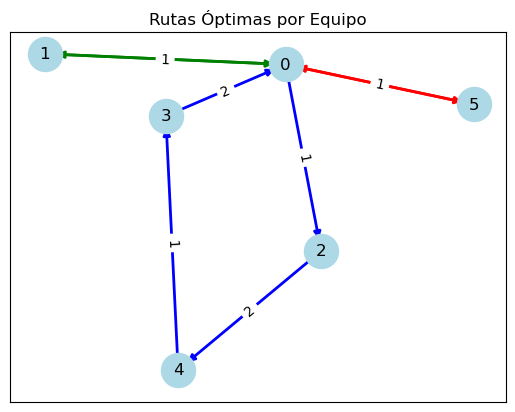

In [91]:
import networkx as nx
import matplotlib.pyplot as plt

def graficar_solucion(model):
    # Crear un grafo dirigido para representar las rutas
    G = nx.DiGraph()

    # Agregar nodos (localidades)
    for i in model.N:
        G.add_node(i)

    # Agregar aristas (rutas) basadas en la solución óptima
    for k in model.K:
        for i in model.N:
            for j in model.N:
                if model.x[i, j, k].value == 1:  # Si la ruta fue seleccionada por el equipo k
                    G.add_edge(i, j, weight=model.c[i, j], team=k)

    # Posiciones de los nodos en un círculo para una visualización simple
    pos = nx.spring_layout(G)

    # Dibujar los nodos
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')

    # Dibujar las etiquetas de los nodos
    nx.draw_networkx_labels(G, pos, font_size=12)

    # Dibujar las aristas con diferentes colores para cada equipo
    colors = ['r', 'g', 'b']  # Colores para los equipos (ajustar según el número de equipos)
    for k in model.K:
        edges_k = [(i, j) for i, j in G.edges if G[i][j]['team'] == k]
        nx.draw_networkx_edges(G, pos, edgelist=edges_k, width=2, edge_color=colors[k-1], arrows=True)

    # Dibujar las etiquetas de las aristas (costos de las rutas)
    edge_labels = {(i, j): f"{G[i][j]['weight']}" for i, j in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Mostrar el gráfico
    plt.title("Rutas Óptimas por Equipo")
    plt.show()

# Llamar a la función para graficar la solución una vez que el modelo esté resuelto
graficar_solucion(model)
